In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
from scipy.special import erfc
from scipy.integrate import quad as qd

In [2]:
class espectro:
    
    # inicialización
    def __init__(self, canales, cuentas, muestra):
        # ponemos todos los datos en arrays y calculamos sus respectivos errores
        
        self.muestra = muestra
        self.cuentas = np.array(cuentas)
        self.canales = np.array(canales)
        self.tiempo = 1000*(50/2048)*np.array(canales) # en picosegundos (50ns/2048ch)
        
        self.err_cuentas = np.array([0.25 + np.sqrt(abs(N)) for N in self.cuentas])
        self.err_canales = np.array([0.5 for ch in self.canales])
        self.err_tiempo = 1000*(50/2048)*self.err_canales # en picosegundos


    # primer intento de calibración
    def calibrar(self, sigma):
        # buscamos el canal que corresponda al maximo en las cuentas y lo restamos
        # despues le sumamos el sigma de calibracion
        
        MAX_CH = np.argmax(self.cuentas)
        
        self.canales = self.canales - self.canales[MAX_CH] + sigma # debería ser (2048/50000)*sigma
        self.tiempo = self.tiempo - self.tiempo[MAX_CH] + sigma


    # gráfico de espectro
    def plot(self, log=False, errs=False):
        fig = plt.figure(figsize=(10,6))
        
        if errs:
            plt.errorbar(self.tiempo, self.cuentas, fmt='.', xerr=self.err_tiempo, yerr=self.err_cuentas, label="Observaciones", zorder=0)
        else:
            plt.plot(self.tiempo, self.cuentas, '.', label="Observaciones", zorder=0)

        plt.xlabel('Tiempo (ps)', fontsize = 13)
        plt.ylabel('Cuentas', fontsize = 13)
        plt.title("Espectro {}".format(self.muestra))
        plt.legend()
        plt.grid()
        
        if log:
            plt.yscale('log')
            
        return fig


    # gráfico de espectro y ajuste con convoluciones
    def plot_conv(self, func, params, n=1, sigma=0, log=False, errs=False, fit_range=[]):
        # seleccionador de función a graficar
        plot_switcher = {
            conv_exp_n: self.plot_conv_exp_n,
            conv_exp_n_sin_lb: self.plot_conv_exp_n_sin_lb,
            conv_exp_n_sigm_fija: self.plot_conv_exp_n_sigm_fija,
            conv_exp_n_sin_lb_sigm_fija: self.plot_conv_exp_n_sin_lb_sigm_fija
        }

        # tomo la función adecuada del seleccionador. por defecto a una lambda.
        method = plot_switcher.get(func, lambda: print("Invalid function"))

        # los datos
        fig = self.plot(log=log,errs=errs)

        # los ajustes
        t = np.linspace(fit_range[0],fit_range[1],num=200)
        method(t, params, n, sigma)

        return fig
    

    def plot_conv_exp_n(self, t, params, n, sigma):
        # el ajuste total
        plt.plot(t, conv_exp_n(params, t, n), label="Ajuste", zorder=n+1)

        # los ajustes individuales
        for i in range(n):  
            par = [params[2*i], params[2*i+1], params[2*n], params[2*n+1], params[2*n+2]]
            plt.plot(t, conv_exp_n(par, t, 1), label=r"$\tau$  {} ps".format(int(par[1])), zorder=i+1)
        plt.legend()


    def plot_conv_exp_n_sin_lb(self, t, params, n, sigma):
        # el ajuste total
        plt.plot(t, conv_exp_n_sin_lb(params,t,n), label="Ajuste", zorder=n+1)
        
        # curvas individuales
        for i in range(n):
            par = [params[2*i], params[2*i+1], params[2*n], params[2*n+1]]
            plt.plot(t, conv_exp_n_sin_lb(par, t, 1), label=r"$\tau$  {}".format(int(par[1])), zorder=i+1)
        plt.legend()


    def plot_conv_exp_n_sigm_fija(self, t, params, n, sigma):
        # el ajuste total
        plt.plot(t, conv_exp_n_sigm_fija(p,t,n,RES), label="Ajuste", zorder=n+1)

        # curvas individuales
        for i in range(n):
            par = [params[2*i], params[2*i+1], params[2*n], params[2*n+1]]
            plt.plot(t, conv_exp_n_sigm_fija(par, t, 1, sigma), label=r"$\tau$  {}".format(int(par[1])), zorder=i+1)
        plt.legend()


    def plot_conv_exp_n_sin_lb_sigm_fija(self, t, params, n, sigma):
        # el ajuste total
        plt.plot(t, conv_exp_n_sin_lb_sigm_fija(params,t,n,sigma), label="Ajuste", zorder=n+1)

        # curvas individuales
        for i in range(n):
            par = [params[2*i], params[2*i+1], params[2*n]]
            plt.plot(t, conv_exp_n_sin_lb_sigm_fija(par,t,1,sigma), label=r"$\tau$  {}".format(int(par[1])), zorder=i+1)
        plt.legend()


    # selección del rango para ajustar
    def select_range(self,fit_range):
        b = self.tiempo
        c = b[b<fit_range[0]]
        d = b[b<=fit_range[1]]
    
        min_index = len(c)
        max_index = len(d)
        return min_index, max_index


    # ajuste
    def fit(self, func, beta_init, pprint=False, use_err = False, hay_extra_args=False, n=1, sigma=0, hay_lb=True, def_fit_range=False, fit_range=[]):
        # función general de ajuste con ODR con cualquier modelo con
        # restricciones en qué sección ajustar
        
        # agrego los argumentos adicionales si los hubiera
        if hay_extra_args:
            if sigma==0:
                model = Model(func, extra_args=[n])
            else:
                model = Model(func, extra_args=[n,sigma])
        else:
            model = Model(func)
        
        # selecciono el rango en el cual ajustar
        if def_fit_range:
            min_index, max_index = self.select_range(fit_range)
        else:
            min_index, max_index = 0, len(self.tiempo)

        x_fit = self.tiempo[min_index:max_index]
        y_fit = self.cuentas[min_index:max_index]
        
        # defino los datos con o sin errores
        if use_err:
            err_x_fit = self.err_tiempo[min_index:max_index]
            err_y_fit = self.err_cuentas[min_index:max_index]
            data_fit= RealData(x_fit, y_fit,sx=err_x_fit, sy=err_y_fit)
        else:
            data_fit= RealData(x_fit, y_fit)
        
        # ajusto y guardo los parámetros relevantes
        odr_fit = ODR(data_fit, model, beta0=beta_init)
        out = odr_fit.run()
        params = np.array(out.beta)
        err_params = np.array(out.sd_beta)
        chi_red_dof = out.res_var  # ODR ya usa esto como estimador de chi_red_dof
        
        # imprimo en pantalla los datos relevantes: por defecto de ODR o convolución
        if pprint:
            out.pprint()
        else:
            print("rango de ajuste: ",fit_range)
            print("params iniciales: ",beta_init,'\n')
            for i in range(n):
                print("Int{}: {}  +/-  {}".format(i,params[2*i],err_params[2*i]))
                print("tau{}: {}  +/-  {}".format(i,params[2*i+1],err_params[2*i+1]),'\n')
            
            if sigma==0:
                print("sigma_RES: {}  +/-  {}".format(params[2*n],err_params[2*n]))
                print("shift: {}  +/-  {}".format(params[2*n+1],err_params[2*n+1]))
            else:
                print("shift: {}  +/-  {}".format(params[2*n],err_params[2*n]))
            
            if hay_lb:
                print("baseline: {}  +/-  {}".format(params[2*n+1+int(0**sigma)],err_params[2*n+1+int(0**sigma)]),'\n')
            
            print("chi2_red: {}".format(chi_red_dof),'\n')
            
        return params, err_params, chi_red_dof
    

    # estimación de los órdenes de magnitud de los taus
    def estimar_tiempos(self):
        # pasamos las cuentas a logaritmo para hacer evidente 
        # cuantos tiempos hay y poder definir una buena funcion de ajuste
        
        log_cuentas = np.log(self.cuentas)
        N_MAX = log_cuentas.size
        
        # las diferencias en log deberian ser constantes en la zona donde
        # domina cada tiempo caracteristico 
        
        diff_log = -1/np.gradient(log_cuentas, self.tiempo)
        
        plt.plot(self.tiempo,diff_log, 'o')
        plt.xlabel("tiempo (ps)")
        plt.ylabel('est_tau')
        plt.ylim(0,2000)
        plt.show()


    # intensidades relativas calculadas integrando las curvas del ajuste
    def int_rel(self,func,B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
        # área de la suma
        I_suma = integral_conv_n(func,B,n,sigma,intervalo)
        
        # diccionario para diferenciar los últimos parámetros de las funciones
        index_dic = {
            conv_exp_n: 3,
            conv_exp_n_sin_lb: 2,
            conv_exp_n_sigm_fija: 2,
            conv_exp_n_sin_lb_sigm_fija: 1
        }

        # últimos parámetros de la función elegida
        last_B = []
        for i in range(index_dic.get(func)):
            last_B.append(B[2*n+i])

        # áreas de las funciones individuales
        I_ind = []
        for i in range(n):
            aux_B = [B[2*i],B[2*i+1]]
            aux_B += last_B
            I_ind.append(integral_conv_n(func,aux_B,1,sigma,intervalo))

        return [[i[0]/I_suma[0], (i[0]/I_suma[0])*np.sqrt((i[1]/i[0])**2 + (I_suma[1]/I_suma[0])**2)] for i in I_ind]


    # intensidades relativas calculadas directamente de los parámetros
    def int_rel_par(self,B,errB,n=1):
        # área de la suma
        A = [[B[2*i],errB[2*i]] for i in range(n)]

        I_suma = [sum([i[0] for i in A]), np.sqrt(sum([i[1]**2 for i in A]))]

        I_ind = [[i[0]/I_suma[0], (i[0]/I_suma[0])*np.sqrt((i[1]/i[0])**2 + (I_suma[1]/I_suma[0])**2)] for i in A]

        return I_ind

In [3]:
# carga de datos de las muestras a analizar
def load_file(file_name):
    data_file = open(file_name, "r")
    ch = []
    cuentas = []
    
    if ".ASC" in file_name:
        for line in data_file:
            if "," in line:
                c, cts, ROI = [float(x) for x in line.split(", ")]
                ch.append(c)
                cuentas.append(cts)
                # el ROI no lo guardo porque no lo uso en ningún lado
    else:
        for line in data_file:
            c, cts = [float(x.replace(",", ".")) for x in line.split("\t")]
            ch.append(c)
            cuentas.append(cts)
    data_file.close()
        
    return np.array(ch), np.array(cuentas)

In [4]:
# FUNCIONES

# gaussiana
def gaussian(B,x):
    return B[0]*np.exp((-(x - B[1])**2)/(2*B[2]**2))

# convolución de una gaussiana con una exponencial
def conv(B,x):
    """ 
    B[0] = amplitud
    B[1] = tau
    B[2] = sigma
    B[3] = corrimiento
    """
    
    T1 = (B[0]/2*B[1])*np.exp(((B[2]**2)/B[1] - 2*(x - B[3]))/(2*B[1]))
    T2 = erfc(((B[2]**2)/B[1] - (x - B[3]))/(np.sqrt(2)*B[2]))
    
    return T1*T2

# convolución de una gaussiana con la suma de n exponenciales
def conv_exp_n(B,x,n):
    """ 
    B[2*i] = amplitud
    B[2*i+1] = tau

    mismos sigma y corrimiento para todas las exp
    B[2*n] = sigma
    B[2*n+1] = corrimiento
    B[2*n+2] = línea de base
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[2*i],B[2*i+1],B[2*n],B[2*n+1]])
        f.append(conv(p[i],x))
    
    return sum(f) + B[2*n+2]

# convolución de una gaussiana con la suma de n exponenciales SIN línea de base
def conv_exp_n_sin_lb(B,x,n):
    """ 
    B[2*i] = amplitud
    B[2*i+1] = tau

    mismos sigma y corrimiento para todas las exp
    B[2*n] = sigma
    B[2*n+1] = corrimiento
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[2*i],B[2*i+1],B[2*n],B[2*n+1]])
        f.append(conv(p[i],x))
    
    return sum(f)

# convolución de una gaussiana con la suma de n exponenciales
def conv_exp_n_sigm_fija(B,x,n,sigm):
    """ 
    B[2*i] = amplitud
    B[2*i+1] = tau

    mismos sigma y corrimiento para todas las exp
    sigm = sigma
    B[2*n] = corrimiento
    B[2*n+1] = línea de base
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[2*i],B[2*i+1],sigm,B[2*n]])
        f.append(conv(p[i],x))
    
    return sum(f) + B[2*n+1]

# convolución de una gaussiana con la suma de n exponenciales SIN línea de base y con sigma FIJA
def conv_exp_n_sin_lb_sigm_fija(B,x,n,sigm):
    """ 
    B[2*i] = amplitud
    B[2*i+1] = tau

    mismos sigma (fija) y corrimiento para todas las exp
    sigm = sigma
    B[2*n] = corrimiento
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[2*i],B[2*i+1],sigm,B[2*n]])
        f.append(conv(p[i],x))
    
    return sum(f)


# mismas funciones pero con los argumentos permutados para poder integrarlas
def swap_conv_exp_n(x,B,n):
    return conv_exp_n(B,x,n)

def swap_conv_exp_n_sin_lb(x,B,n):
    return conv_exp_n_sin_lb(B,x,n)

def swap_conv_exp_n_sigm_fija(x,B,n,sigm):
    return conv_exp_n_sigm_fija(B,x,n,sigm)

def swap_conv_exp_n_sin_lb_sigm_fija(x,B,n,sigm):
    return conv_exp_n_sin_lb_sigm_fija(B,x,n,sigm)


# integrales posibles
def int_conv_exp_n(B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
    return qd(swap_conv_exp_n,intervalo[0],intervalo[1],args=(B,n))

def int_conv_exp_n_sin_lb(B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
    return qd(swap_conv_exp_n_sin_lb,intervalo[0],intervalo[1],args=(B,n))

def int_conv_exp_n_sigm_fija(B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
    return qd(swap_conv_exp_n_sigm_fija,intervalo[0],intervalo[1],args=(B,n,sigma))

def int_conv_exp_n_sin_lb_sigm_fija(B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
    return qd(swap_conv_exp_n_sin_lb_sigm_fija,intervalo[0],intervalo[1],args=(B,n,sigma))


# cálculo de la integral
def integral_conv_n(func,B,n=1,sigma=0,intervalo=[-np.inf,np.inf]):
    int_func = {
        conv_exp_n: int_conv_exp_n,
        conv_exp_n_sin_lb: int_conv_exp_n_sin_lb,
        conv_exp_n_sigm_fija: int_conv_exp_n_sigm_fija,
        conv_exp_n_sin_lb_sigm_fija: int_conv_exp_n_sin_lb_sigm_fija
    }
    
    I = int_func.get(func)

    return I(B,n,sigma,intervalo)

No handles with labels found to put in legend.


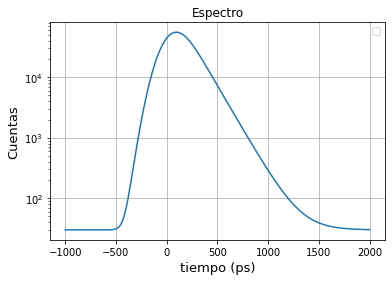

In [5]:
# grafico para chequear la función
t = np.linspace(-1000,2000,num=200)
fig = plt.figure()        
plt.plot(t, conv_exp_n([1e3, 150, 117, 0, 30],t,1))
plt.xlabel('tiempo (ps)', fontsize = 13)
plt.ylabel('Cuentas', fontsize = 13)
plt.title("Espectro")
plt.legend()
plt.grid()
plt.yscale('log')
#plt.xlim(-1000,0)
plt.show()

Beta: [2932.06374938 5796.97464618  117.95513132]
Beta Std Error: [30.18391211  1.97305513  0.98401519]
Beta Covariance: [[ 1.20910370e+03  1.65696677e+00 -1.11298006e+01]
 [ 1.65696677e+00  5.16643458e+00  1.29739010e-02]
 [-1.11298006e+01  1.29739010e-02  1.28503838e+00]]
Residual Variance: 0.7535073716710591
Inverse Condition #: 0.031329320726813374
Reason(s) for Halting:
  Sum of squares convergence


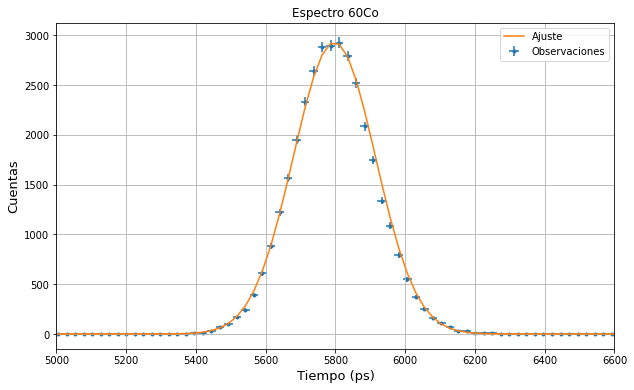

 
 ----------------------------------------  
Resolución:  117.95513132194966 +/- 0.984015189997875 ps
 ----------------------------------------  
 


In [6]:
# determinación de la RESOLUCIÓN experimental usando Co

# tomo los datos del archivo y los cargo en un espectro
carpeta = "resolucion/"
file_res = "COSET.ASC"
canales_res, cuentas_res = load_file(carpeta+file_res)

spec_res = espectro(canales_res, cuentas_res, '60Co')

# ajusto una gaussiana para obtener la resolución
rango_ajuste = [5.0e3,6.6e3]
beta_init_res = [3000, 5850, 111]
param_res, err_param_res, chi_redof_res = spec_res.fit(gaussian, beta_init_res, pprint=True, use_err=True,def_fit_range=True, fit_range=rango_ajuste)

# grafico
fig_res = spec_res.plot(errs=True)
plt.xlim(5e3, 6.6e3)
plt.plot(spec_res.tiempo, gaussian(param_res, spec_res.tiempo), label="Ajuste")
plt.legend()
plt.show()

# RESOLUCION 
RES, ERR_RES =  param_res[2], err_param_res[2]

print(" \n ----------------------------------------  ")
print("Resolución: ", RES, "+/-", ERR_RES , "ps")
print(" ----------------------------------------  \n ")

rango de ajuste:  [5000.0, 6600.0]
params iniciales:  [3000, 0.73, 118, 5800.0, 0] 

Int0: 3000.0  +/-  0.0
tau0: 0.73  +/-  0.0 

sigma_RES: 118.0  +/-  0.0
shift: 5800.0  +/-  0.0
baseline: 0.0  +/-  0.0 

chi2_red: 0.0 

<ipython-input-4-3940085d0f38>:16: RuntimeWarning: overflow encountered in exp
  T1 = (B[0]/2*B[1])*np.exp(((B[2]**2)/B[1] - 2*(x - B[3]))/(2*B[1]))
<ipython-input-4-3940085d0f38>:19: RuntimeWarning: invalid value encountered in multiply
  return T1*T2
<ipython-input-4-3940085d0f38>:16: RuntimeWarning: overflow encountered in exp
  T1 = (B[0]/2*B[1])*np.exp(((B[2]**2)/B[1] - 2*(x - B[3]))/(2*B[1]))
<ipython-input-4-3940085d0f38>:19: RuntimeWarning: invalid value encountered in multiply
  return T1*T2


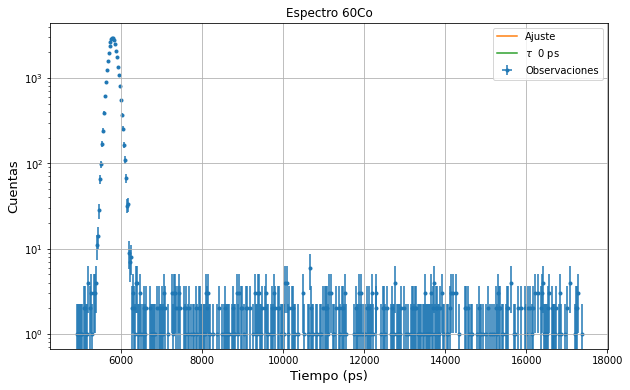

In [7]:
# ajusto una convolución para obtener la resolución: no funciona
rango_ajuste = [5.0e3,6.6e3]
beta_init_res = [3000, 0.73, 118, 5.8e3, 0]
param_res, err_param_res, chi_redof_res = spec_res.fit(conv_exp_n, beta_init_res,hay_extra_args=True, n=1, use_err=True,def_fit_range=True, fit_range=rango_ajuste)

# grafico
fig_res = spec_res.plot_conv(conv_exp_n,param_res,n=1,log=True,errs=True,fit_range=rango_ajuste)
plt.show()

rango de ajuste:  [-1200, 9981.236381321949]
params iniciales:  [0.5, 2200, 55, 386, 350, 189, 117.95513132194966, -10, 20] 

Int0: 0.6182862316371283  +/-  0.025639061155781077
tau0: 2213.416266340238  +/-  32.04957979076486 

Int1: 69.7904083134465  +/-  13.097326225965658
tau1: 403.18022763286757  +/-  16.65826455292966 

Int2: 365.6600965539724  +/-  40.07017117899969
tau2: 179.03967097838844  +/-  17.83326252122071 

sigma_RES: 187.7016251625132  +/-  1.9142236117422773
shift: -6.45426625750673  +/-  5.23415996712451
baseline: 17.65969906023903  +/-  0.8703742124168782 

chi2_red: 0.9463830054909189 



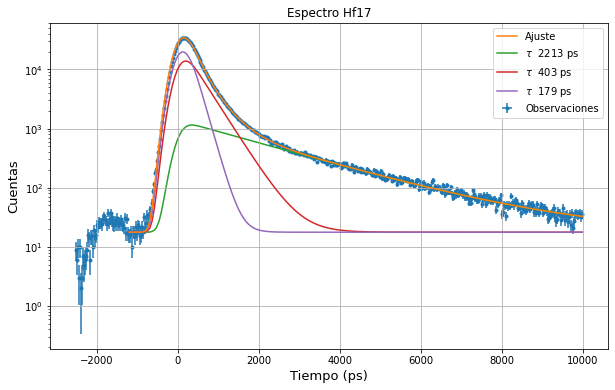

In [8]:
# determinación de los taus del kapton y del aire usando una muestra de referencia de Hf

# tomo los datos del archivo, los cargo en un espectro y hago una primera calibración
carpeta = "datos/Hf/"
file_ref_Hf17 = "REFSET.ASC"
canales_ref_Hf17, cuentas_ref_Hf17 = load_file(carpeta+file_ref_Hf17)

spec_ref_Hf17 = espectro(canales_ref_Hf17, cuentas_ref_Hf17, 'Hf17')
spec_ref_Hf17.calibrar(RES)

# ajusto una convolución con 3 exponenciales
'''
kapton ~ 386 ps
fondo ~ 1200/2200 ps ?
Hf ~ 189
'''
n = 3
beta_init_ref_Hf17 = [0.5, 2200, 55, 386, 350, 189, RES, -10, 20]
rango_ajuste = [-1200,spec_ref_Hf17.tiempo[-1]]

param_ref_Hf17, err_param_ref_Hf17, chi_redof_ref_Hf17 = spec_ref_Hf17.fit(conv_exp_n, beta_init_ref_Hf17, use_err=True, hay_extra_args=True, n=n, def_fit_range=True, fit_range=rango_ajuste)

# grafico
fig_ref_Hf17 = spec_ref_Hf17.plot_conv(conv_exp_n,param_ref_Hf17,n=n,log=True,errs=True,fit_range=rango_ajuste)
#plt.xlim(-2e3, -500)
#plt.ylim(1e1,3e2)
plt.show()

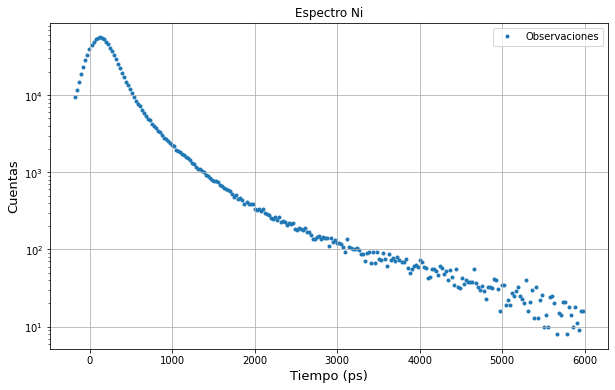

<ipython-input-2-571830a44b6c>:200: RuntimeWarning: divide by zero encountered in true_divide
  diff_log = -1/np.gradient(log_cuentas, self.tiempo)


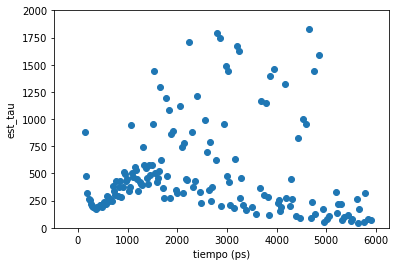

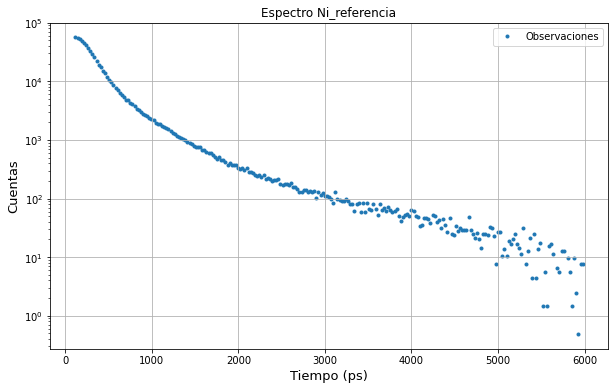

<ipython-input-2-571830a44b6c>:194: RuntimeWarning: invalid value encountered in log
  log_cuentas = np.log(self.cuentas)
<ipython-input-2-571830a44b6c>:200: RuntimeWarning: divide by zero encountered in true_divide
  diff_log = -1/np.gradient(log_cuentas, self.tiempo)


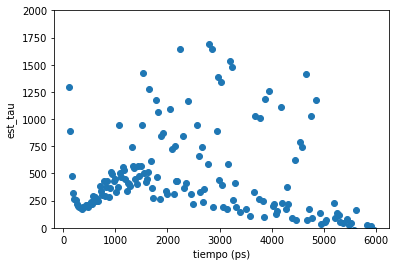

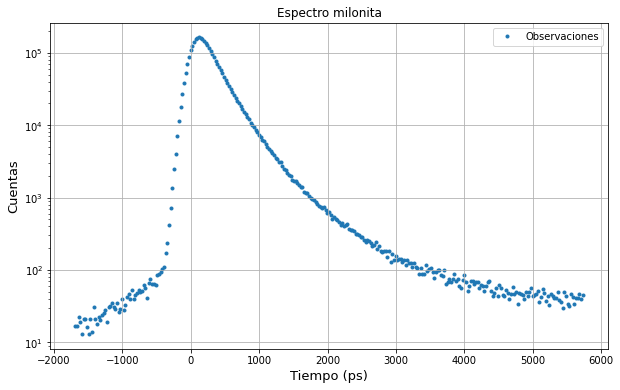

<ipython-input-2-571830a44b6c>:200: RuntimeWarning: divide by zero encountered in true_divide
  diff_log = -1/np.gradient(log_cuentas, self.tiempo)


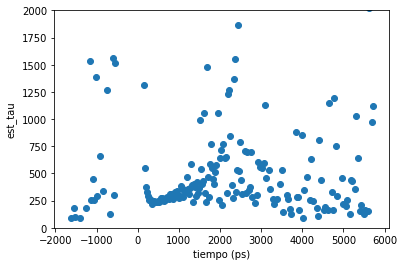

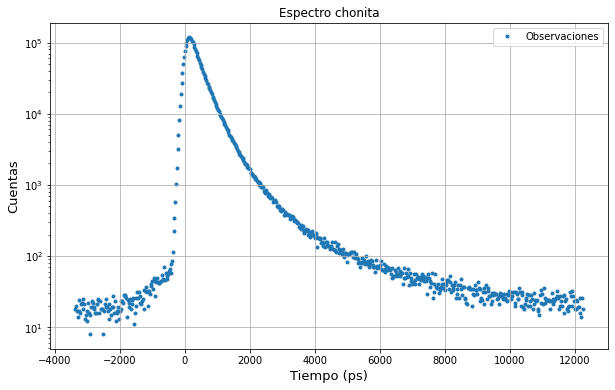

<ipython-input-2-571830a44b6c>:200: RuntimeWarning: divide by zero encountered in true_divide
  diff_log = -1/np.gradient(log_cuentas, self.tiempo)


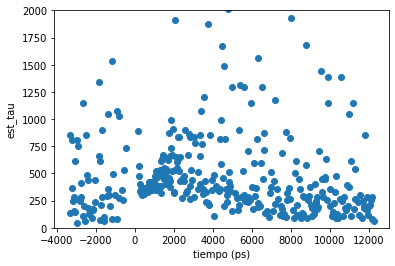

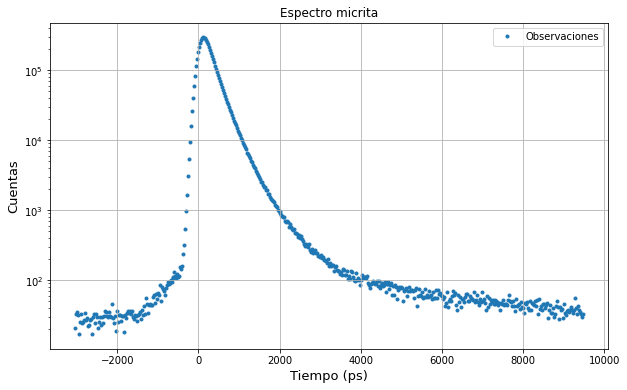

<ipython-input-2-571830a44b6c>:200: RuntimeWarning: divide by zero encountered in true_divide
  diff_log = -1/np.gradient(log_cuentas, self.tiempo)


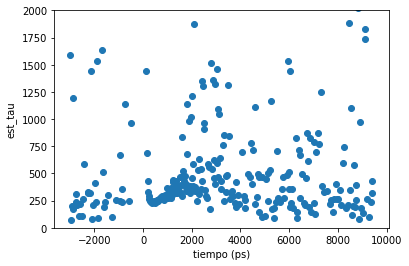

In [9]:
# espectros de las muestras y calibración

# los nombres. la referencia es Ni.
carpeta = "datos/"
file_names = ['Ni.txt','Ni_referencia.txt', "milonita.ASC", "chonita.ASC", "micrita.ASC"]

specs = {}

for file_name in file_names:
    
    # para cada muestra armamos un espectro
    nombre_muestra = file_name.split(".")[0]
    ch_spec, cuentas_spec = load_file(carpeta+file_name)
    
    # como ya tenemos al resolución ademas calibramos bien el tiempo
    specs[nombre_muestra] = espectro(ch_spec, cuentas_spec, nombre_muestra)
    specs[nombre_muestra].calibrar(RES)
    specs[nombre_muestra].plot(log=True)
    #plt.xlim(-600,0)
    plt.show()
    specs[nombre_muestra].estimar_tiempos()

1906.979599999996


<function matplotlib.pyplot.show(close=None, block=None)>

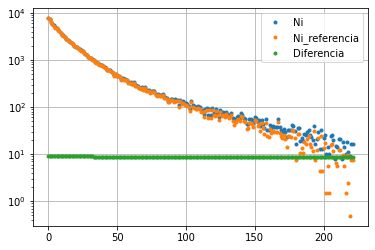

In [10]:
# verifico qué tan distintos son los dos espectros de Ni: son casi iguales! 
a = specs['Ni'].cuentas
b = specs['Ni_referencia'].cuentas

a = a[a<8e3]
b = b[b<8e3]
c = a - b
print(sum(c))

fig = plt.figure()
plt.plot(a,'.',label="Ni")
plt.plot(b,'.',label="Ni_referencia")
plt.plot(c,'.',label="Diferencia")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show

rango de ajuste:  [-175.01361867805034, 5977.33013132195]
params iniciales:  [0.1, 1200, 10.0, 386, 1000.0, 110, 117.95513132194966, 20] 

Int0: 0.6654963091142683  +/-  0.05701999526206627
tau0: 1400.1447351151644  +/-  31.386716486806822 

Int1: 58.68992445759215  +/-  4.673917710332136
tau1: 377.58339976926214  +/-  9.268127480287307 

Int2: 1474.9208397173352  +/-  196.24763763259972
tau2: 107.17520514621356  +/-  7.4537598382251025 

sigma_RES: 127.66418067780104  +/-  3.464174775637719
shift: 22.182565037072763  +/-  4.759955691670573
chi2_red: 0.9217004587991419 



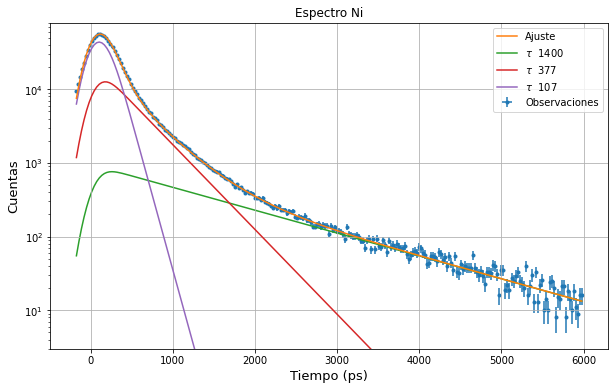

In [11]:
#############################################################################################
## determinación de los taus del KAPTON y del FONDO usando una muestra de referencia de Ni ##
#############################################################################################
# AJUSTANDO SIGMA sin línea de base

# parámetros del ajuste
'''
kapton ~ 386 ps
fondo ~ 1200/2200 ps ?
Ni ~ 110 ps
'''
n = 3
beta_init = [1e-1, 1200, 1e1, 386, 1e3, 110, RES, 20]
rango_ajuste = [specs['Ni'].tiempo[0],specs['Ni'].tiempo[-1]]

# ajuste
p, err_p, chi_red = specs['Ni'].fit(func=conv_exp_n_sin_lb, beta_init = beta_init, hay_extra_args=True, n=n, hay_lb=False, def_fit_range=True, fit_range=rango_ajuste, use_err= True)

# grafico
fig = specs['Ni'].plot_conv(conv_exp_n_sin_lb, p, n=n, log=True, errs=True, fit_range=rango_ajuste)
plt.ylim(3,8e4)
plt.show()

rango de ajuste:  [-175.01361867805034, 5977.33013132195]
params iniciales:  [0.1, 1200, 10.0, 386, 1000.0, 110, 20, 5] 

Int0: 0.2911183303213114  +/-  0.08078610144785912
tau0: 1917.6777396738578  +/-  225.96351931155854 

Int1: 44.39213717325162  +/-  4.380704824796218
tau1: 418.57656844186613  +/-  13.532578083025031 

Int2: 1072.3807472254098  +/-  56.3329355826167
tau2: 127.40562527050298  +/-  4.701870170417513 

shift: 13.842884167770647  +/-  3.41576997531427
baseline: -14.242267432232298  +/-  5.926520019637851 

chi2_red: 0.9089721335604612 



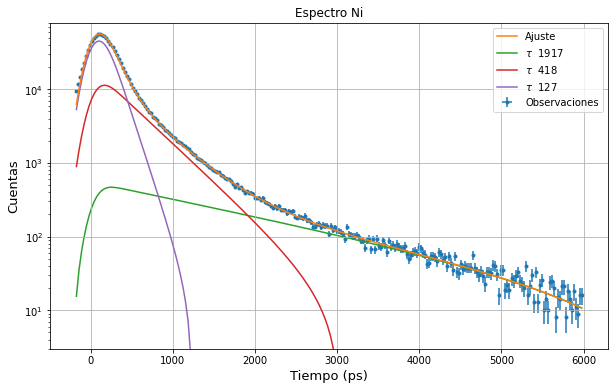

In [12]:
#############################################################################################
## determinación de los taus del KAPTON y del FONDO usando una muestra de referencia de Ni ##
#############################################################################################
# CON SIGMA FIJA

# parámetros del ajuste
'''
kapton ~ 386 ps
fondo ~ 1200/2200 ps ?
Ni ~ 110 ps
'''
n = 3
beta_init = [1e-1, 1200, 1e1, 386, 1e3, 110, 20, 5]
rango_ajuste = [specs['Ni'].tiempo[0],specs['Ni'].tiempo[-1]]

# ajuste
p, err_p, chi_red = specs['Ni'].fit(func=conv_exp_n_sigm_fija, beta_init = beta_init, hay_extra_args=True, n=n, sigma = RES, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

# grafico
fig = specs['Ni'].plot_conv(conv_exp_n_sigm_fija, p, n=n, sigma=RES, log=True, errs=True, fit_range=rango_ajuste)
plt.ylim(3,8e4)
plt.show()

rango de ajuste:  [-175.01361867805034, 5977.33013132195]
params iniciales:  [0.1, 1200, 10.0, 386, 1000.0, 110, 20] 

Int0: 0.641037483171808  +/-  0.05888184913412905
tau0: 1414.0635927699332  +/-  33.63353900653094 

Int1: 54.68768757193115  +/-  4.835670600579405
tau1: 386.41070469736013  +/-  9.971049727501374 

Int2: 1128.0499989736202  +/-  67.80585127827224
tau2: 121.38591809263582  +/-  4.980965362328854 

shift: 15.514802677575956  +/-  3.562993977656661
chi2_red: 0.9495131520533203 

Int_rel_0: 0.0005417010380154921 +/- 5.868644185538114e-05
Int_rel_1: 0.04621317458349349 +/- 0.004872919392328004
Int_rel_2: 0.9532451243784911 +/- 0.07925648040653972


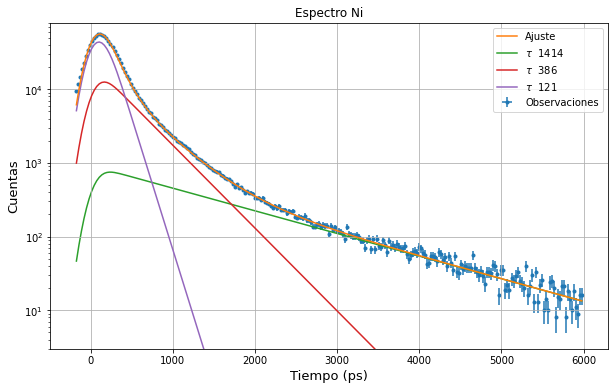

In [13]:
#############################################################################################
## determinación de los taus del KAPTON y del FONDO usando una muestra de referencia de Ni ##
#############################################################################################
# CON SIGMA FIJA y sin línea de base

# parámetros del ajuste
'''
kapton ~ 386 ps
fondo ~ 1200/2200 ps ?
Ni ~ 110 ps
'''
n = 3
beta_init = [1e-1, 1200, 1e1, 386, 1e3, 110, 20]
rango_ajuste = [specs['Ni'].tiempo[0],specs['Ni'].tiempo[-1]]

# ajuste
p, err_p, chi_red = specs['Ni'].fit(func=conv_exp_n_sin_lb_sigm_fija, beta_init = beta_init, hay_extra_args=True, n=n, sigma = RES, hay_lb=False, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

# intensidades relativas
intensidades_rel = specs['Ni'].int_rel_par(p,err_p,n)  #(conv_exp_n_sin_lb_sigm_fija,p,n=n,sigma=RES,intervalo=rango_ajuste)
for i in range(n):
    print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

# grafico
fig = specs['Ni'].plot_conv(conv_exp_n_sin_lb_sigm_fija, p, n=n, sigma=RES, log=True, errs=True, fit_range=rango_ajuste)
plt.ylim(3,8e4)
plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [10.0, 1200, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 20.79720554042309  +/-  1.5291394311089925
tau0: 623.0342621623781  +/-  9.732195478357884 

Int1: 1314.1706228177245  +/-  21.025714572810468
tau1: 233.23232481658732  +/-  2.228668447634596 

sigma_RES: 104.53570406962245  +/-  1.2270854626458652
shift: -1.4665318264038012  +/-  2.3571519846788087
baseline: 41.03994125442293  +/-  0.9395296367187305 

chi2_red: 0.849700062037688 

Int_rel_0: 0.015578806543975811 +/- 0.0011715713635420037
Int_rel_1: 0.9844211934560241 +/- 0.02212976116206837


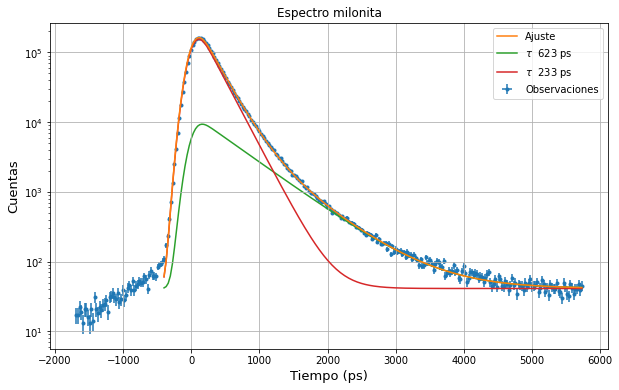


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [10.0, 1200, 100.0, 386, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 9.218034458014905  +/-  2.0851139669940606
tau0: 723.0963099959525  +/-  31.725938252324344 

Int1: 552.487441400678  +/-  160.40324804462426
tau1: 283.24997432620296  +/-  17.294969087713206 

Int2: 1312.8795380264023  +/-  124.24612539948222
tau2: 150.0233369268859  +/-  22.68391594256482 

sigma_RES: 110.2914616797561  +/-  1.5818499273612328
shift: 13.266239329672322  +/-  3.9921460884634468
baseline: 37.45521921201355  +/-  1.2842520074371178 

chi2_red: 0.7018723259553902 

Int_rel_0: 0.004917373386502457 +/- 0.0012330956894519149
Int_rel_1: 0.2947251990752036 +/- 0.09132059418822848
Int_rel_2: 0.700357427538294 +/- 0.1006956812809564


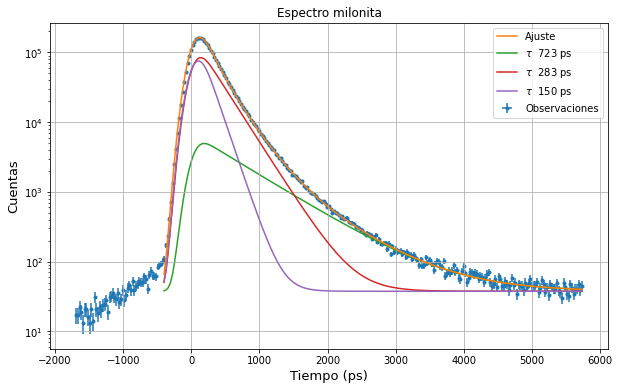


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [10.0, 1200, 100.0, 386, 1000.0, 200, 1000.0, 2200, 117.95513132194966, 10, 35] 

Int0: 3.846902776098039  +/-  1238560.605857507
tau0: 303.8057943237947  +/-  969678.6180177804 

Int1: 428.5290603940755  +/-  1238356.385449681
tau1: 297.6246502241922  +/-  9319.935436876242 

Int2: 1320.7526183555376  +/-  792.8607508158887
tau2: 165.37438706352913  +/-  59.21301473487809 

Int3: 7.9081314614378115  +/-  6.806044356625775
tau3: 743.9838311050025  +/-  104.99535982250977 

sigma_RES: 109.74452255180572  +/-  1.6961485322144056
shift: 11.499354877147846  +/-  4.390357411447416
baseline: 36.9369248789554  +/-  2.037829260722794 

chi2_red: 0.7085349606182056 

Int_rel_0: 0.0021844534800031234 +/- 703.3166917790245
Int_rel_1: 0.2433390838667897 +/- 743.6781391160129
Int_rel_2: 0.7499858512973407 +/- 745.9010869759882
Int_rel_3: 0.004490611

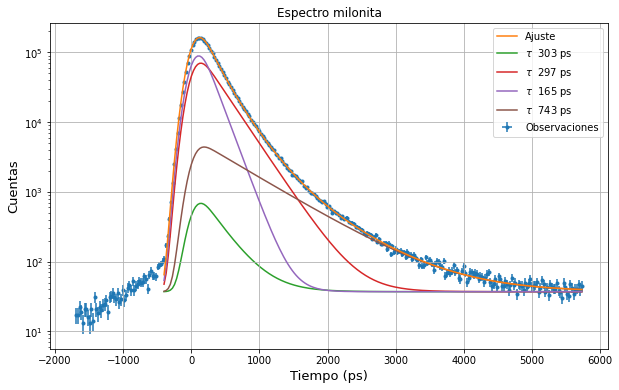

In [14]:
# Determinación de los taus de MILONITA ajustando sigma para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
milonita ~ ?
'''
betas = [
    [1e1, 1200, 1e3, 200, RES, 10, 35],
    [1e1, 1200, 1e2, 386, 1e3, 200, RES, 10, 35],
    [1e1, 1200, 1e2, 386, 1e3, 200, 1e3, 2200, RES, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['milonita'].tiempo[-1]]

    # ajuste
    p, err_p, chi_red = specs['milonita'].fit(func=conv_exp_n, beta_init = betas[n-2], hay_extra_args=True, n=n, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['milonita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['milonita'].plot_conv(conv_exp_n, p, n=n, log=True, errs=True, fit_range=rango_ajuste)
    plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [1.0, 1200, 1000.0, 200, 10, 35] 

Int0: 27.468880213679586  +/-  2.0391605983754832
tau0: 588.5691485309709  +/-  9.269083478295789 

Int1: 1533.4257978724686  +/-  21.25007640795123
tau1: 217.2180562088336  +/-  2.2547172678828424 

shift: 9.925025454570843  +/-  2.627961020482455
baseline: 42.48694450971797  +/-  1.073230487808588 

chi2_red: 1.2617360268071407 

Int_rel_0: 0.017598163796265782 +/- 0.0013283907966614083
Int_rel_1: 0.9824018362037342 +/- 0.01912760179936087


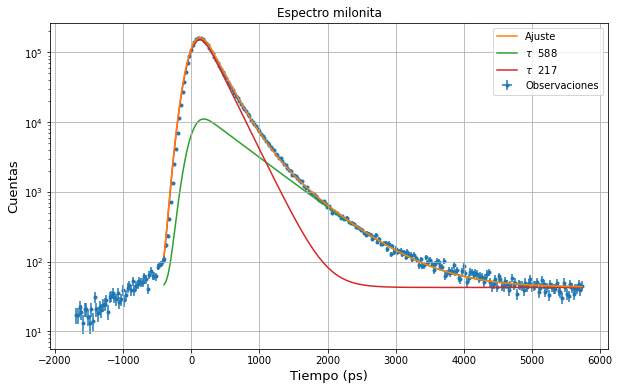


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [1.0, 7200, 100.0, 386, 1000.0, 200, 10, 35] 

Int0: 4.095416135623578  +/-  1.3541884010240217
tau0: 849.5726986746859  +/-  59.73376184487 

Int1: 331.93092858754545  +/-  71.07088327277334
tau1: 321.26301916954304  +/-  16.510951182534154 

Int2: 1802.3492140830424  +/-  76.89278471355365
tau2: 153.36992374357104  +/-  10.063529763644036 

shift: 22.21463103103431  +/-  2.68652822487483
baseline: 33.6632235357614  +/-  1.9276756360648801 

chi2_red: 0.8290032775653867 

Int_rel_0: 0.0019151996564672306 +/- 0.0006401861622142121
Int_rel_1: 0.15522574003457662 +/- 0.03409409617767361
Int_rel_2: 0.8428590603089562 +/- 0.05474130053763847


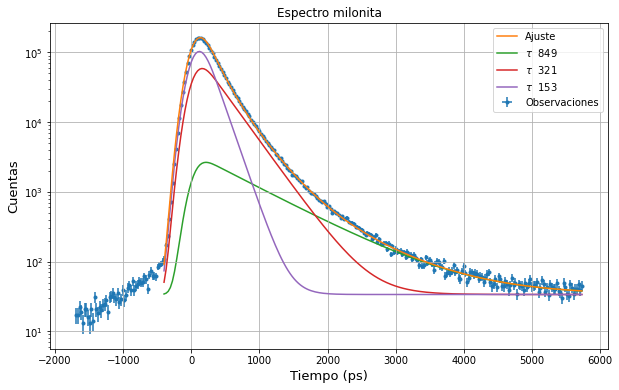


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 5733.18950632195]
params iniciales:  [10.0, 850, 100.0, 386, 1000.0, 200, 1000.0, 200, 10, 35] 

Int0: 8.276379244739404  +/-  4.114673918190579
tau0: 732.6610036617295  +/-  64.38132959090343 

Int1: 338.8933039282972  +/-  727.9560137298896
tau1: 300.00466874729483  +/-  94.95237402084895 

Int2: 736.093716797693  +/-  322.12695487498917
tau2: 195.30867064285175  +/-  114.15665028563893 

Int3: 4695.519827673902  +/-  4124.375606302728
tau3: 57.18512948688312  +/-  36.54901697271961 

shift: 35.24439806202859  +/-  6.3607773114246395
baseline: 37.199107504934155  +/-  1.6801680886889452 

chi2_red: 0.7250942271024376 

Int_rel_0: 0.0014322010220329316 +/- 0.0012612521521634442
Int_rel_1: 0.05864440498600021 +/- 0.13298748240482944
Int_rel_2: 0.1273786691420361 +/- 0.10807438736143041
Int_rel_3: 0.8125447248499308 +/- 0.9264013728047942


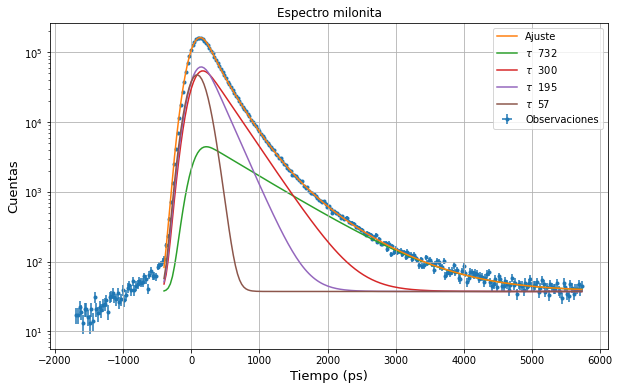

In [31]:
# Determinación de los taus de MILONITA con SIGMA FIJA para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
milonita ~ ?
'''
betas = [
    [1e0, 1200, 1e3, 200, 10, 35],
    [1e0, 7200, 1e2, 386, 1e3, 200, 10, 35],
    [1e1, 850, 1e2, 386, 1e3, 200, 1e3, 200, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['milonita'].tiempo[-1]]
    
    # ajuste
    p, err_p, chi_red = specs['milonita'].fit(func=conv_exp_n_sigm_fija, beta_init = betas[n-2], hay_extra_args=True, n=n, sigma=RES, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['milonita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['milonita'].plot_conv(conv_exp_n_sigm_fija, p, n=n, sigma=RES, log=True, errs=True, fit_range=rango_ajuste)
    #plt.xlim(-2e3,-200)
    #plt.ylim(1e1,5e2)
    plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [10.0, 1200, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 3.6447833796282465  +/-  0.19240157439835767
tau0: 1236.5008457563335  +/-  16.89560835316248 

Int1: 530.9169098045262  +/-  6.413064707432235
tau1: 351.099023404335  +/-  2.1984801699176666 

sigma_RES: 98.03876483181902  +/-  1.6086849021306036
shift: -20.896026717733758  +/-  2.914748536245919
baseline: 25.88595141840822  +/-  0.5361873426954098 

chi2_red: 1.6230283827289438 

Int_rel_0: 0.006818265180802308 +/- 0.00036910998157366616
Int_rel_1: 0.9931817348191976 +/- 0.01691216728284122


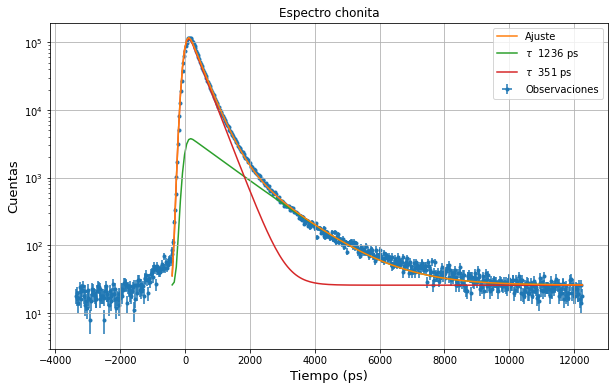


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [10.0, 1200, 100.0, 386, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 0.5163329140436611  +/-  0.08618388303169609
tau0: 1968.3735359630102  +/-  87.08265672729371 

Int1: 55.375548251803146  +/-  9.171850167440573
tau1: 583.4651438523654  +/-  22.24168037811124 

Int2: 632.0168629975652  +/-  11.36220088745868
tau2: 279.5804542228661  +/-  6.697428599245119 

sigma_RES: 108.24516696724396  +/-  1.3069072153643297
shift: 0.6805097076283084  +/-  2.5175420891988063
baseline: 19.409562585255532  +/-  0.7930927515163033 

chi2_red: 0.8340442054606555 

Int_rel_0: 0.0007505834435519353 +/- 0.00012629294178161376
Int_rel_1: 0.08049839273252317 +/- 0.013441997690830843
Int_rel_2: 0.9187510238239248 +/- 0.0255570084388737


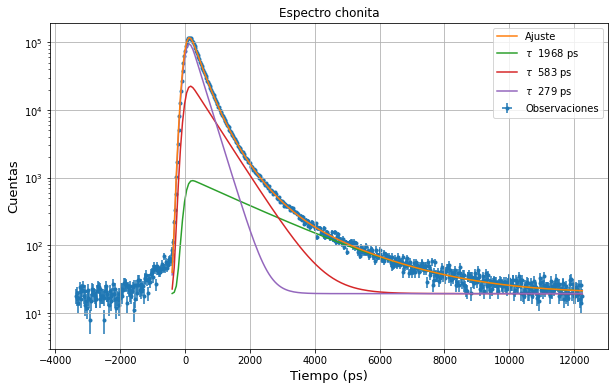


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [10.0, 1900, 100.0, 586, 1000.0, 386, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 0.5918640808117248  +/-  0.09567892056136643
tau0: 1901.9203606999295  +/-  76.58567954707843 

Int1: 67.41584286519118  +/-  15.308249203987636
tau1: 558.4280980555232  +/-  21.002019813706408 

Int2: 646.3215027108073  +/-  165.15554584288554
tau2: 269.17281749126283  +/-  8.431065940488256 

Int3: -180.37305142056144  +/-  24283899.08517036
tau3: 3.1939392763854926  +/-  226237.97975642778 

sigma_RES: 109.38491352886581  +/-  17.625885800314716
shift: 5.795664735322396  +/-  54.859611962535304
baseline: 19.834381676196664  +/-  0.7433135434100219 

chi2_red: 0.8441290070692036 

Int_rel_0: 0.0011084507064526722 +/- 50.41145173059463
Int_rel_1: 0.12625726255855457 +/- 5742.079336586603
Int_rel_2: 1.2104392706055138 +/- 55049.81007121502
Int_rel_3

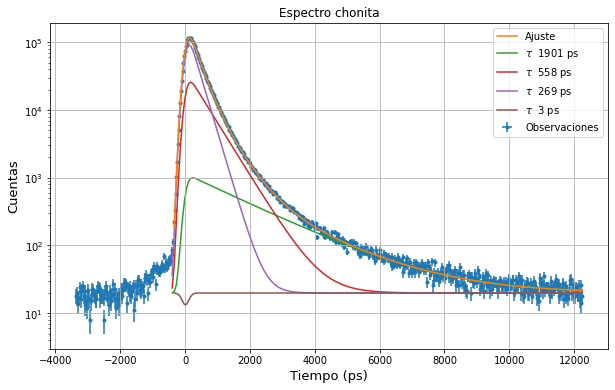

In [16]:
# Determinación de los taus de CHONITA ajustando sigma para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
chonita ~ ?
'''
betas = [
    [1e1, 1200, 1e3, 200, RES, 10, 35],
    [1e1, 1200, 1e2, 386, 1e3, 200, RES, 10, 35],
    [1e1, 1900, 1e2, 586, 1e3, 386, 1e3, 200, RES, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['chonita'].tiempo[-1]]

    # ajuste
    p, err_p, chi_red = specs['chonita'].fit(func=conv_exp_n, beta_init = betas[n-2], hay_extra_args=True, n=n, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['chonita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['chonita'].plot_conv(conv_exp_n, p, n=n, log=True, errs=True, fit_range=rango_ajuste)
    plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [1.0, 1200, 1000.0, 200, 10, 35] 

Int0: 4.677607386140744  +/-  0.25461748967741815
tau0: 1164.4406968968174  +/-  16.268840540596777 

Int1: 608.3276597857612  +/-  5.595542441092763
tau1: 332.5719736907567  +/-  2.1429186703540823 

shift: -11.221718889741146  +/-  3.1615080815093757
baseline: 26.72970811529274  +/-  0.5923774108299453 

chi2_red: 2.129380866669516 

Int_rel_0: 0.00763061532524977 +/- 0.00042117092982708914
Int_rel_1: 0.9923693846747502 +/- 0.01286645806314661


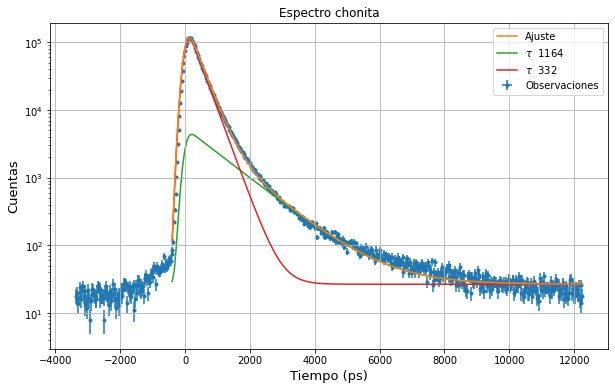


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [1.0, 1200, 100.0, 386, 1000.0, 200, 10, 35] 

Int0: 0.7028357154260387  +/-  0.08930066028592587
tau0: 1824.422654123909  +/-  61.30574901141087 

Int1: 93.19145843554368  +/-  11.364852296950655
tau1: 521.8725759306675  +/-  14.564531452007554 

Int2: 718.0664117842216  +/-  12.210697266160206
tau2: 244.8556969964103  +/-  6.61668981935783 

shift: 11.48625931636664  +/-  2.4335133812471494
baseline: 20.276190735937796  +/-  0.6899560761632912 

chi2_red: 0.9162531418433406 

Int_rel_0: 0.0008656031139050432 +/- 0.00011140997595142065
Int_rel_1: 0.11477336003373295 +/- 0.014194029081472012
Int_rel_2: 0.884361036852362 +/- 0.02358524668622647


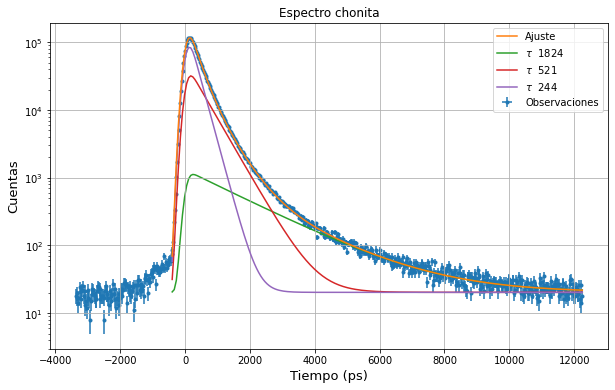


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 12251.744193821949]
params iniciales:  [10.0, 1900, 100.0, 586, 1000.0, 386, 1000.0, 200, 10, 35] 

Int0: 0.9031065844053905  +/-  0.10034258806303997
tau0: 1714.4138703413455  +/-  49.30435273961661 

Int1: 126.36116923607149  +/-  15.602556961456335
tau1: 487.06204705664  +/-  13.02516831638244 

Int2: 732.4874092479478  +/-  52.96445297215434
tau2: 227.14316588357687  +/-  9.749974559861105 

Int3: -137.7834710343262  +/-  2341887.862311089
tau3: 3.443037738904776  +/-  29027.447057409398 

shift: 14.262103034803772  +/-  11.348720660454248
baseline: 21.121931655234572  +/-  0.6221018062156551 

chi2_red: 0.9275196301756794 

Int_rel_0: 0.0012508952151219458 +/- 4.057597366345374
Int_rel_1: 0.17502317523095756 +/- 567.7322659637922
Int_rel_2: 1.0145701639066238 +/- 3291.016844481726
Int_rel_3: -0.1908442343527034 +/- -3302.2977581198816
<ipython-input-4-3940085d0f38>:16

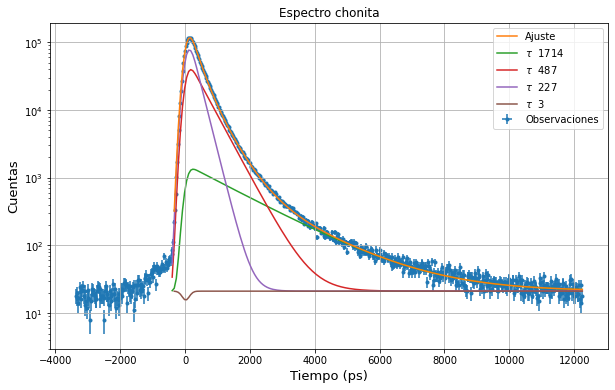

In [17]:
# Determinación de los taus de CHONITA con SIGMA FIJA para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
chonita ~ ?
'''
betas = [
    [1e0, 1200, 1e3, 200, 10, 35],
    [1e0, 1200, 1e2, 386, 1e3, 200, 10, 35],
    [1e1, 1900, 1e2, 586, 1e3, 386, 1e3, 200, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['chonita'].tiempo[-1]]
    
    # ajuste
    p, err_p, chi_red = specs['chonita'].fit(func=conv_exp_n_sigm_fija, beta_init = betas[n-2], hay_extra_args=True, n=n, sigma=RES, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['chonita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['chonita'].plot_conv(conv_exp_n_sigm_fija, p, n=n, sigma=RES, log=True, errs=True, fit_range=rango_ajuste)
    #plt.xlim(-2e3,-200)
    #plt.ylim(1e1,5e2)
    plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [10.0, 1200, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 12.940556133879719  +/-  1.0650006398411684
tau0: 753.4122882307406  +/-  13.611797792168037 

Int1: 2187.724460630498  +/-  36.40442441754004
tau1: 248.5385294440284  +/-  2.105848387763028 

sigma_RES: 99.76417501691056  +/-  1.6418543747630845
shift: -2.447281254812525  +/-  3.1650536683554553
baseline: 46.821137466569084  +/-  0.7301451719735891 

chi2_red: 1.7433880481004331 

Int_rel_0: 0.005880293472791296 +/- 0.0004936325708696122
Int_rel_1: 0.9941197065272086 +/- 0.023330857370645774


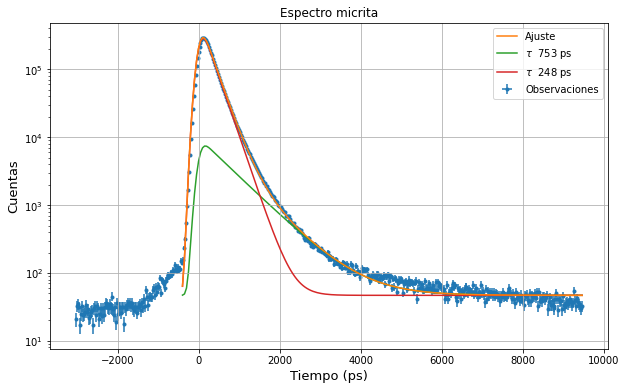


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [10.0, 1200, 100.0, 386, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 0.10128848893848735  +/-  0.03323891315406334
tau0: 2663.693342880767  +/-  366.97258095596965 

Int1: 83.71630310652074  +/-  11.235261019956829
tau1: 491.12292367102737  +/-  14.054601951845207 

Int2: 2580.7837013074  +/-  51.70334314201973
tau2: 216.3442054962938  +/-  3.3174962119065934 

sigma_RES: 106.5684658782927  +/-  1.211257456773224
shift: 12.818782408181168  +/-  2.46013364402329
baseline: 29.10653396468137  +/-  3.1294530431269076 

chi2_red: 0.8269588288735528 

Int_rel_0: 3.801262470609329e-05 +/- 1.2497069179008429e-05
Int_rel_1: 0.03141794734150221 +/- 0.004262390257131118
Int_rel_2: 0.9685440400337917 +/- 0.02731990713764863


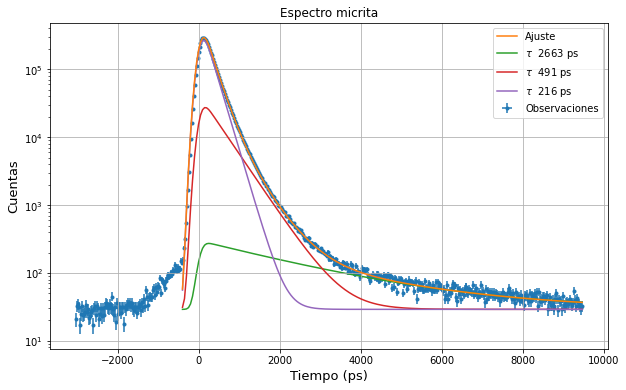


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [10.0, 2600, 100.0, 486, 1000.0, 300, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 0.05505622754814173  +/-  0.024512935764940378
tau0: 3457.8141396647247  +/-  790.4353255183784 

Int1: 50.510002471013934  +/-  10.743320624692014
tau1: 536.5884629718206  +/-  23.818265928842507 

Int2: 1842.054215753267  +/-  151.79116992349867
tau2: 234.39843146037987  +/-  7.592438131266908 

Int3: 4933.349390798031  +/-  5687.768184039759
tau3: 68.98991453973875  +/-  38.75750682669315 

sigma_RES: 112.61754404275301  +/-  2.8257099139405266
shift: 33.07257614177537  +/-  11.900690002384916
baseline: 23.7526259141678  +/-  5.922862343404412 

chi2_red: 0.7951662940267661 

Int_rel_0: 8.065701770420658e-06 +/- 7.622167691068077e-06
Int_rel_1: 0.007399682733405142 +/- 0.006365661873627135
Int_rel_2: 0.26985975267231027 +/- 0.2260387718565706
Int_

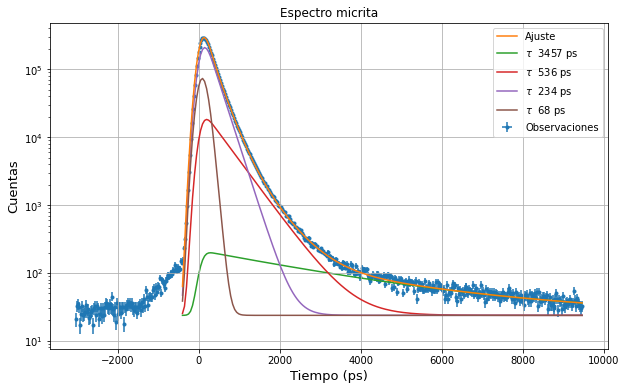

In [18]:
# Determinación de los taus de MICRITA ajustando sigma para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
micrita ~ ?
'''
betas = [
    [1e1, 1200, 1e3, 200, RES, 10, 35],
    [1e1, 1200, 1e2, 386, 1e3, 200, RES, 10, 35],
    [1e1, 2600, 1e2, 486, 1e3, 300, 1e3, 200, RES, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['micrita'].tiempo[-1]]

    # ajuste
    p, err_p, chi_red = specs['micrita'].fit(func=conv_exp_n, beta_init = betas[n-2], hay_extra_args=True, n=n, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['micrita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['micrita'].plot_conv(conv_exp_n, p, n=n, log=True, errs=True, fit_range=rango_ajuste)
    plt.show()


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [1.0, 1200, 1000.0, 200, 10, 35] 

Int0: 13.963338834277007  +/-  1.1689409466606429
tau0: 742.9872657571552  +/-  13.861758644168876 

Int1: 2535.768607142026  +/-  29.357100867205357
tau1: 236.8650700658635  +/-  1.9196031366878852 

shift: 8.33095714354792  +/-  3.3784610270666158
baseline: 46.68839407395365  +/-  0.8372801639205029 

chi2_red: 2.334518160989569 

Int_rel_0: 0.005476394825076557 +/- 0.00046277899829280254
Int_rel_1: 0.9945236051749236 +/- 0.01624484557468573


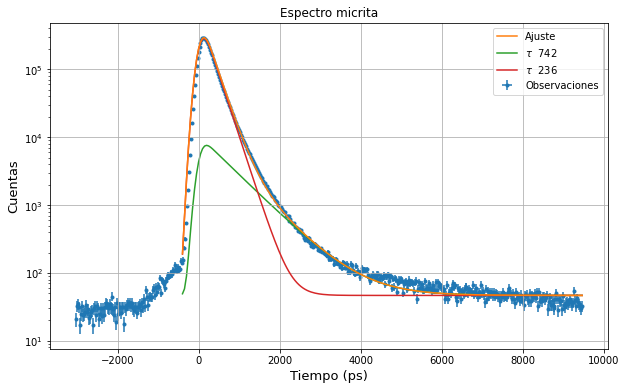


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [1.0, 1200, 100.0, 386, 1000.0, 200, 10, 35] 

Int0: 0.21466034852529348  +/-  0.057854569645426644
tau0: 2042.1770806368293  +/-  190.7980484432553 

Int1: 144.81910780980095  +/-  17.325302749929573
tau1: 439.1476416830359  +/-  11.13530709881287 

Int2: 3081.52245502529  +/-  54.631485855536056
tau2: 193.62748871468918  +/-  3.416913313643059 

shift: 25.95777404582753  +/-  2.4474455949191154
baseline: 33.49056504388003  +/-  1.928595577797301 

chi2_red: 0.9984956715825879 

Int_rel_0: 6.652924470458781e-05 +/- 1.796964919715948e-05
Int_rel_1: 0.044883491187675366 +/- 0.005428460374822985
Int_rel_2: 0.9550499795676199 +/- 0.023968282637786168


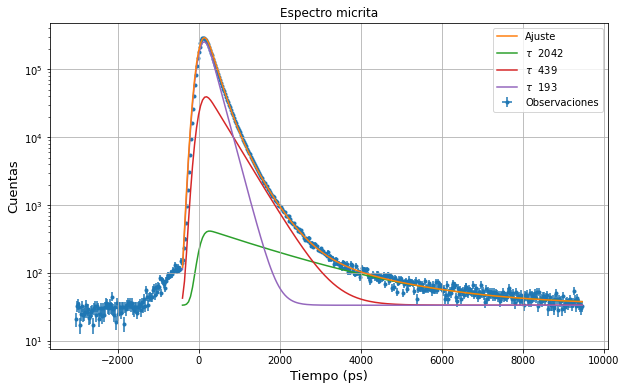


 ---------------------------------------------------------------------------------------
rango de ajuste:  [-400, 9468.541068821949]
params iniciales:  [10.0, 2600, 100.0, 486, 1000.0, 300, 1000.0, 200, 117.95513132194966, 10, 35] 

Int0: 0.03843238316021684  +/-  0.018897806553225458
tau0: 4214.939004478389  +/-  1268.8263844515684 

Int1: 41.26524798938238  +/-  9.338562797782055
tau1: 556.9440071222999  +/-  26.078700582157534 

Int2: 1606.6747310980375  +/-  146.50971712921228
tau2: 241.25750482422734  +/-  7.716648907531054 

Int3: 5963.724985976162  +/-  2254.5752563904543
tau3: 74.95528619014092  +/-  17.55614192728869 

shift: 41.45235781842399  +/-  4.303397784840514
baseline: 18.326122890909854  +/-  9.256892329978665 

chi2_red: 0.8182478696891086 

Int_rel_0: 5.0491172807795605e-06 +/- 2.900013109644331e-06
Int_rel_1: 0.005421289537270242 +/- 0.0020235273962656004
Int_rel_2: 0.2110795241492171 +/- 0.06554378877430164
Int_rel_3: 0.783494137196232 +/- 0.3765877112977852


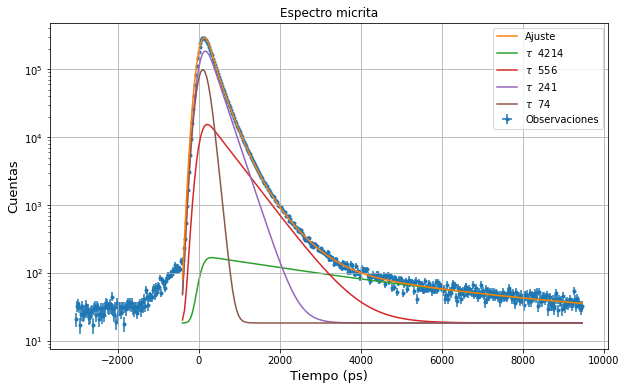

In [19]:
# Determinación de los taus de MICRITA con SIGMA FIJA para 2, 3 y 4 exponenciales
'''
fondo ~ 1200 ps
kapton ~ 386 ps
micrita ~ ?
'''
betas = [
    [1e0, 1200, 1e3, 200, 10, 35],
    [1e0, 1200, 1e2, 386, 1e3, 200, 10, 35],
    [1e1, 2600, 1e2, 486, 1e3, 300, 1e3, 200, RES, 10, 35]
    ]

for n in [2,3,4]:
    print('\n',"---------------------------------------------------------------------------------------")
    rango_ajuste = [-400,specs['micrita'].tiempo[-1]]
    
    # ajuste
    p, err_p, chi_red = specs['micrita'].fit(func=conv_exp_n_sigm_fija, beta_init = betas[n-2], hay_extra_args=True, n=n, sigma=RES, def_fit_range=True, fit_range=rango_ajuste, use_err=True)

    # intensidades relativas
    intensidades_rel = specs['micrita'].int_rel_par(p,err_p,n)
    for i in range(n):
        print("Int_rel_{}: {} +/- {}".format(i,intensidades_rel[i][0],intensidades_rel[i][1]))

    # grafico
    fig = specs['micrita'].plot_conv(conv_exp_n_sigm_fija, p, n=n, sigma=RES, log=True, errs=True, fit_range=rango_ajuste)
    #plt.xlim(-2e3,-200)
    #plt.ylim(1e1,5e2)
    plt.show()

In [20]:
"""
HACER:
- ¿agregar funciones de integración y normalización a la class espectro?
- Ajustar Ni
- Agregarle etiquetas a las curvas
"""

'\nHACER:\n- ¿agregar funciones de integración y normalización a la class espectro?\n- Ajustar Ni\n- Agregarle etiquetas a las curvas\n'